In [65]:
from ultralytics import YOLO
from utils.autocomplete import yolo_utils as yolo
from utils.autocomplete import references_utils as ref
import cv2
import json
from utils.extraction.file_handlers import read_json
import torch
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [66]:
# функции используются локально и не требуют переноса в модули

def get_true_pdf_name(doc_data: dict, ind) -> str:
    for index, file in enumerate(doc_data.get('Files', [])):
        if index == ind:
            return file.get('Id')
        
def get_pdf_name(path: Path, ind=0) -> Path:
    try:
        for subpath in path.glob('*'):
            if subpath.name == 'document.json':
                doc_data = read_json(subpath)
        for subpath in path.glob('*'):
            if subpath.name == get_true_pdf_name(doc_data, ind) + '.pdf':
                return subpath
    except TypeError:
        return

In [71]:
# model =YOLO('./runs/detect/train/weights/best.pt')
# model = YOLO('/local_data/models/model_yolo_5_classes.pt')
model_5_classes = YOLO('/data/docs/vh/yolo/models/model_5_classes.pt')
model_handwrite = YOLO('/data/docs/vh/yolo/models/model_yolo_handwrite.pt')
# PATH_TO_DETECT_PDF = Path('/data/docs/vh/incoming_2023_feb/')
PATH_TO_DETECT_PDF = Path('/data/docs/vh/latest_docs/')

with open('./data/comparison.json', 'r') as f:
    comparison = json.load(f)

# Предсказательная модель на основе нейроной сети YOLOv8

### Задачи исследования: ###
- определить в тексте документа следующие сущности:  
    - отправитель (sender)
    - подписант (signer)
    - дата создания документа (date)
    - исходящий номер документа (numder)
    - краткое содержание документа (content)  
- найденным отправителю и подписанту сопоставить соответствующие идентификационные номера.  
- получить метрики качества исследования.
- на основе метрик сделать вывод о работоспособности исследуемого алгоритма поиска сущностей.

Для выполнения поставленных задач в данном исследовании используется алгоритм, который укрупнённо можно разделить на три части:  
    - YOLO (нахождение прямоугольных периметров ограничивающих иcкомые сущности на изображении документа (bounding boxes)).  
    - text recognition (распознование текста в найденных bounding boxes).  
    - matching ID (обработка распознанных текстов, фильтрация, поиск идентификаторов для отправителя и подписанта).   
      
Для исследования выбраны документы имеющие вид письма, все остальные документы исключены, так как требуют задания заказчиком таргетных классов. Из представленных 12833 документов, письма составляют 11646 документов или 90.8% всех документов

   ## 1. Нахождение прямоугольных периметров ( Предсказание bounding boxes)

Гипотеза - текст в документах типа "Письмо" можно визуально разбить на кластеры, где каждому кластеру будет соответствовать определённая сущность - отправитель, дата, номер, контент, получатель, текст письма, печать, подписант и так далее. То есть, если посмотреть на документ, то даже не читая его, визуально видно разделение сущностей. Для визуального разделения на кластеры подходят модели CV. В данном случае используется модель YOLO версии 8 так как она отлично зарекомендовала себя именно в определении сущностей на изображениях и видео, модель представленна в виде отдельной удобной для использования библиотеки для языка програмирования Python. Изначально модель предназначена для детектирования физических предметов на изображениях и видео, таких как  люди, автомобили, самолёты, животные, посуда и т. д. Но эта же модель после дополнительного обучения отлично показала себя для определения bounding boxes текстовых сущностей.

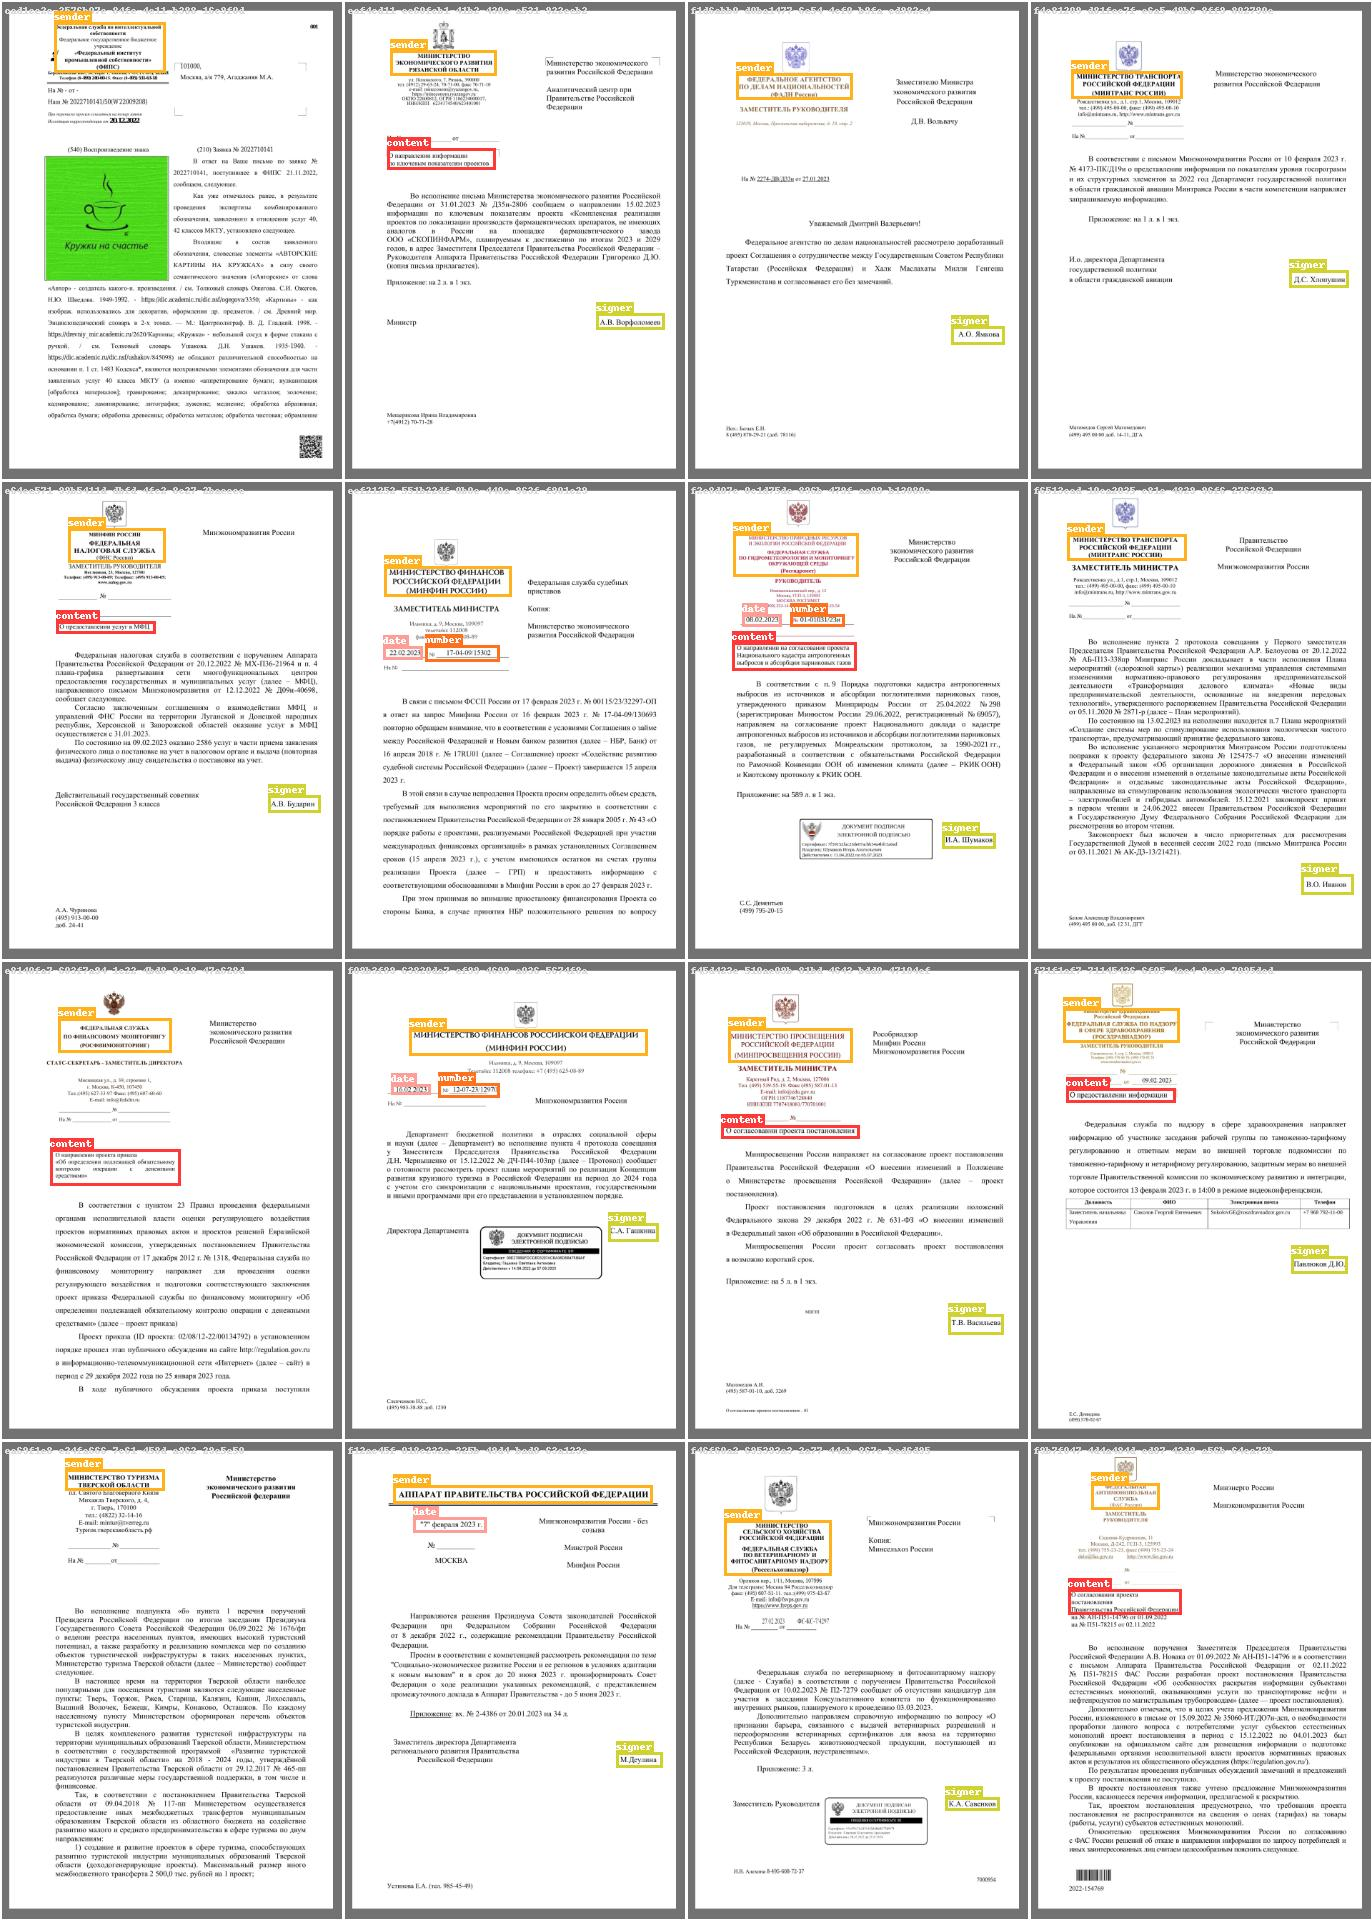

Визуальное разделение сщностей в тексте


In [4]:
jpg = './runs/detect/train/val_batch2_labels.jpg'
from IPython.display import Image, display
display(Image(filename=jpg))
print('Визуальное разделение сщностей в тексте')

Перед разметкой, документы были преобразованы в формат jpeg, так как модель работает с растровыми форматами изображений. Та же логика используется и дальше при детектировании классов в документе - сначала преобразование в формат jpeg, далее детектирование моделью.
Разметка документов производилась с помощью инструмента Label Images, локально установленным на сервере заказчика. Необходимо помнить, что при локальной работе Label Images без доступа к сети интернет возникают определённые проблемы. Сам инструмент интуитивно понятен и особого рассмотрения не требует. Достаточно сказать, что необходимо из предложенных вариантов разметки изображений выбрать bounding boxes и назначить 5 классов в следующей последовательности - 'content', 'date', 'number', 'sender', 'signer'. Последовательность классов также представленна в документе './data/conf_all_classes.yaml. Модель обучалась на 400 документах из выборки 2019 года и валидировалась на 100 документах. Далее эта же модель была дообучена уже на выборке из новых документов 2023 года (800 документов на обучение и 200 документов на валидацию). Полученые метрики по определению bounding boxes представленны ниже.

In [4]:
metrics = model_5_classes.val()  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.0.58 🚀 Python-3.10.9 torch-2.0.0+cpu CPU
Model summary (fused): 218 layers, 25842655 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /data/docs/vh/yolo/test/labels.cache... 200 images, 17 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:49<00:00,  3.83s/it]
                   all        200        545      0.983      0.974      0.989      0.767
               content        200         67       0.96          1      0.985      0.802
                  date        200         92          1      0.958       0.99      0.729
                number        200         77      0.981      0.974      0.992       0.77
                sender        200        174      0.977      0.962      0.984      0.843
                signer        200        135      0.999      0.978      0.994      0.689
Speed: 0.8ms preprocess, 165.4ms inference, 0.0ms lo

Необходимо заметить, что не во всех представленных 200 валидационных документах есть заявленные классы. Связанно это с тем что в ввыборке есть документы не являющиеся письмами и соответственно не содержащими искомые классы. Также во многих документах отсутствуют заполненные поля даты и исходящих номеров, а также во многих документах отсутствует поле контент.   
Видно, что бОльшая часть метрик precision и recall  преодолевает точность в 90%, самые низкие показатели для  номеров документов, так как сами номера часто пишутся от руки и в любом месте документа без какой либо логики. Сами номера в зависимости от организации имеют разную цифро-буквенную структуру и сложно поддаются стандартизации. Но и при этом точность определения номеров весьма высока: precission - 0.893, recall - 0.899. 
Самые высокие показатели точности для классов content и  signer. Такая высокая точность обусловленна стандартным написанием этих двух классов. Класс content чаще всего начинатся с букв "О" или "Об",  что легко считывается моделью и повышает вероятность определения именно этого класса. То же верно и для signer, так как в подавляющем большинтсве случаев подписант находится в нижнем правом углу документа, справа от печати, ниже текста. Подписант всегда одна из самых коротких сущностей, чаще всего представленная тремя заглавными буквами, двумя точками и телом фамилии. 

#### ВЫВОД: 
моделль YOLOv8 отлично справлется с предсказанием прямоугольных периметров позиции текстовых сущностей, даже при относительно небольших обучающих данных (1200 документов) и небольшом количестве эпох обучения (120-200). Трудо затраты для разметки документов составляют 16 рабочих часов, что весьма экономичный показатель. Видна явная корреляция качества модели с качеством искомых классов: единообразие в представлении экземпляров классов, заметные маркеры и отличительные особенности сильно повышают точность модели ( "О", "Об", ФИО, жирный текст капслоком, позиционирование в документе и т. д.). 

## 2. Распознавание текста в найденных bounding boxes. Text Recognition.

In [72]:
# df_yolov = pd.read_csv('./data/df_yolo_feb_new.csv', index_col=[0])
# df_yolov = pd.read_pickle('./data/df_yolo_feb_new.pickle')
df_yolov = pd.read_pickle('./data/df_yolo_latest_new.pickle')
df_meta = yolo.get_meta(PATH_TO_DETECT_PDF)
df_meta.out_reg_date = df_meta.out_reg_date.apply(lambda row: row.date())

100%|██████████| 4212/4212 [00:06<00:00, 605.43it/s]


In [73]:
df_predict = yolo.merge_dfs_by_id(df_yolov, df_meta)
df_predict.kind.value_counts()

Письмо                                    3477
Заявление о госуслуге                      158
Поручение                                   71
Распоряжение                                40
Постановление                               39
Протокол                                    19
Письмо ВЭБ                                  11
Указ                                        11
Материалы к заседанию Правительства РФ       5
Телеграмма                                   2
Повестка заседания Правительства РФ          2
Name: kind, dtype: int64

In [74]:
df_predict = df_predict[df_predict.kind == 'Письмо']

В первую очередь оставим документы вида "Письмо".  
Для изучения текстов в предсказанных bounding boxes необходимо сравнивать их с истинными значениями экземпляров классов. Для этого сопоставим каждой найденной сущности истинную сущность.  
df_yolov - датафрейм с предсказанными текстовыми блоками для каждого документа.  
df_meta - датафрейм с истинными классами, для каждого документа.  
df_predict - объеденённый датайфрейм, где каждому предсказанному классу для каждого документа сопоставлен истинный класс

### 2.1 Рапознавание текста для sender

Прежде чем исследовать предсказанные текстовые блоки, произведём фильтрацию и очистку текста. Для подписанта приведём все найденные инициалы к виду ФИО для отправителя удалим лишние не буквенно-цифровые символы. Заменим пустые сущности значением "не определён"

In [75]:
df_predict = yolo.clear_text_signer_sender(df_predict, 'signer', 'sender')

При сравнении предсказанной сущности отправителя выявленны основные моменты:  
    - предсказанный текст совпадает с истинным;    
    - предсказанный текст по смыслу такой же как и истинный, но написание различается ("Министерство внутренних дел" - "МВД");   
    - предсказанный текст является ниже стоящей организацией по отношению к истинному отправителю;  
    - предсказанный текст не совпадает с истинным не по смыслу, не по содержанию;  
    - предсказанный текст отсутствует.  

predict_sender - предсказанный отправитель,  
sender - истинный отправитель.

In [76]:
df_predict[['predict_sender', 'sender']].head(20)

,predict_sender,sender
0,министерство экономического развития республик...,дом правительства республики северная осетия а...
1,правительство хабаровского края,правительство хабаровского края
2,федеральная таможенная служба фтс россии,федеральная таможенная служба фтс россии
4,не определён,_арбитражный суд ярославской области
5,правительство рф,правительство рф
7,минтруд россии,минтруд россии
8,министерство строительства и жилищно коммуналь...,министерство строительства и жилищно коммуналь...
9,минтранс россии,минтранс россии
10,министерство финансов российской федерации ми...,министерство финансов российской федерации ми...
11,правительство хабаровского края,правительство хабаровского края


**Правильное предсказание**: текст совпадает с истинной сущностью.  
**Очевидные ошибки**: это ошибка модели YOLOv8 в предсказании периметров сущностей, когда модель предсказала ложную сущность; либо модель вообще не предсказала никакой сущности.  
**Неочевидные ошибки, разночтения**: текст не совпадает, а смысл одинаковый; модель правильно предсказала то что нашла в тексте, но при регистрации документа была указана выше стоящая организация: "Министерство Культуры Ставропольского края" - "Правительство Ставропольского края".

Очевидные ошибки, это ошибки предыдущего уровня (предсказания YOLO) их исправление зависит от улучшения предсказательного качества модели.
Неочевидные ошибки, по большей части не ошибки как таковые,  а разночтение при предсказании и сравнении с той информацией которая была назначена экземплярам документов при регистрации. Так например модель находит в тексте следующего отправителя: "министерство промышленности и торговли российской федерации федеральное агентство по техническому регулированию и метрологии  росстандарт" в то время как при регистрации данного документа отправителем был обозначен "росстандарт", или другой случай, модель нашла отправителя "министерство транспорта российской федерации  минтранс россии", тогда как при регистрации был определён отправитель "минтранс россии". Другими словами модель YOLO и распознование текста верно предсказали отправителя, были найденны именно те организации, которые и являются отправителями, но сравнивать данные сущности для получения метрик или использовать предсказанного отправителя для сопоставления с соответствующим идентификатором не имеет ни какого смысла, так как при попытке получить метрики, такие метрики будут заранее занижены и не будут отображать действительность. Также и при сопоставлении при поиске идентификаторов, идентификаторы не будут найдены, так как тексты предсказанные и истинные слишком отличаются.

#### 2.1.1 Исследование ошибок разночтения сендера

Гипотеза:   
    модель находит в тексте документа отправителей такими как они записаны в документе. При регистрации отправитель
    записывается в сокращённой или в иной форме. Логично предположить, что для каждого предсказанного отправителя в множестве       предсказанных отправителей будет соответствовать один единственный истинный отправитель записанный также, сокращённо или       изменённо.  

Чтобы проверить эту гипотезу, достаточно сгрупировать датайфрейм по предсказанным отправителям и если для каждого такого отправителя будет несколько истинных отправителей, то сопоставляемым будет тот отправитель, который встречается либо больше чем один раз, либо большее количество раз чем все остальные. Например, если модель в некотором количестве документов предсказала отправителя "министерство транспорта российской федерации", а истинным для этих документов является "минтранс россии", то логично предположить, что эти две сущности являются равноправными и истинными и просто необходиом заменить текст "министерство транспорта российской федерации" на текст "минтранс россии" и уже дальше искать в справочнике партнёров идентификатор именно для "минтранс россии".  

#### 2.1.2 Справочник сопоставлений

In [9]:
comparison

{'министерство финансов россииской федерации  федеральная таможенная служба  фтс россии': 'федеральная таможенная служба  фтс россии',
 'губернатор ульяновской области': 'правительство ульяновской области',
 'министерство министерство къырым промислово  полтики промышленной политики джумхуриетининъ санайы республики крим республики крым сиясети назирлиги': 'правительство республики крым г. симферополь',
 'ин министерство транспорта российской федерации  федеральное агентство морского и речного транспорта  росморречфлот': 'федеральное агентство морского и речного транспорта  росморречфлот',
 'республика  хуссар ирыстоны финансты министрад': '_министерство финансов республики южная осетия',
 'минэкономразвития россии федеральная служба государственной статистики  росстат': 'федеральная служба государственной статистики  росстат',
 'глава республики бурятия': 'администрация главы и правительства республики бурятия',
 'правительство хабаровского края': 'правительство хабаровского края',
 '

Далее, все предсказанные отправители были сопоставлены с этим справочником и при нахождении таких сопаставлений - заменены. Для сравнения эффективности справочника сопоставлений сравним метрики до применения справочника и после.

#### 2.1.3 Метрики  для предсказанного отправителя

До применения справочника сопоставлений:  
recall sender - 0.6874404091184884  
precision sender - 0.3192337696108174

После применения справочника сопоставлений:

In [10]:
# удалить
# df_predict.predict_signer = df_predict.predict_signer.apply(lambda row: row if row else 'не определён')

In [77]:

print('recall sender')
df_predict = yolo.get_features_with_metrics_for_yolov_predicts(df_predict)
len(df_predict[df_predict.recall_sender_yolov >= 0.9])/ df_predict.shape[0]

recall sender


0.8078803566292782

In [78]:
print('precision sender')
len(df_predict[df_predict.precision_sender_yolov >= 0.9])/ df_predict.shape[0]

precision sender


0.7584124245038827

Важно отметить, что для создания справочника соспоставлений были использованы документы за декабрь 2022 года, март и апрель 2023 года. Валидация производится на данных за февраль 2023 года.  
Очевиден рост качества предсказаний. Так precission вырос на 46%, а recall на 14% (цифры могут меняться при разных выборках). Более высокий рост precision, чем recall обусловлен тем что мы избавились от лишних слов в предиктах. То есть иными словами, при регистрации часто используют сокращённую форму записи отправителя. Данный подход во многом решил проблему разночтений, но не решил её окончательно. Также частично решилась проблема записи при регистрации вышестоящих организаций а не фактических отправителей. В данном случае, запись вместо фактических подписантов, вышестоящих организаций и как следествие негативное влияние таких разночтений на конечную метрику, можно и не считать ошибкой вовсе. При использовании модели в бизнесе, она будет предсказывать фактических отправителей, что в зависимости от логики бизнеса может и не являться ошибкой. 

При изучении метрик очевидно, что подавляющая часть отправителей предсказана правильно (9383 из 11646 документов, 80.5%).
Самое большое количество ошибок связанно с тем что модель YOLO не предсказала для данного документа класс отправителя (1265 из 11646 документов 10.8%).  
Следующий большой кластер ошибок ( recall = 0.667, 0.75) связан в большинстве случаев с записью при регистрации выше стоящих инстанций. В общем случае из всей выборки таких документов ориентировочно около 5%

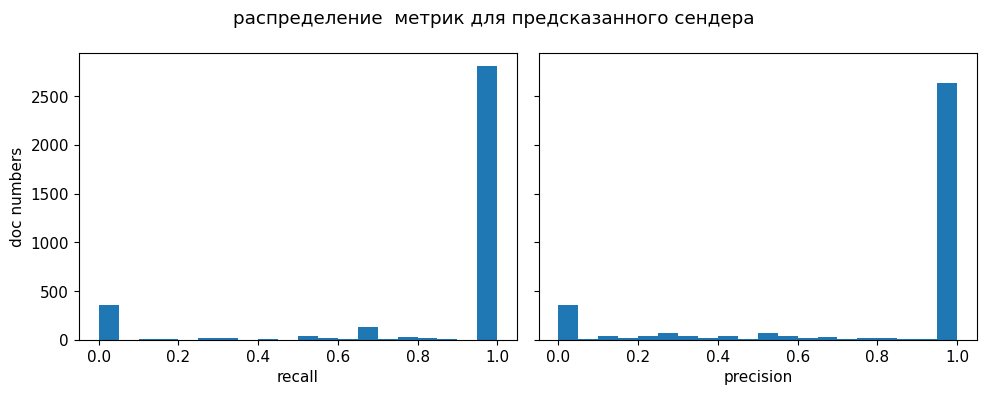

In [79]:
recall =  df_predict.recall_sender_yolov.to_list()
precision = df_predict.precision_sender_yolov.to_list()
n_bins = 20

fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True, tight_layout=True)
fig.suptitle('распределение  метрик для предсказанного сендера')
axs[0].hist(recall, bins=n_bins)
axs[0].set_xlabel('recall')
axs[0].set_ylabel('doc numbers')
axs[1].hist(precision, bins=n_bins)
axs[1].set_xlabel('precision')
plt.show()

In [80]:
df_predict.recall_sender_yolov.value_counts().sort_values(ascending=False).head(20)

1.000    2808
0.000     357
0.667     128
0.500      41
0.750      26
0.333      20
0.250      16
0.800      15
0.600      14
0.400       6
0.625       5
0.875       5
0.857       5
0.714       4
0.167       4
0.818       3
0.833       3
0.889       2
0.556       2
0.700       2
Name: recall_sender_yolov, dtype: int64

In [81]:
df_predict[df_predict.recall_sender_yolov ==0.667][['doc_id','sender', 'predict_sender']].head(30)

,doc_id,sender,predict_sender
0,f958f2f5-8a03-4f02-b2ca-a5fa245a181a,дом правительства республики северная осетия а...,министерство экономического развития республик...
15,7e521678-3962-4284-ba3a-0779bed133d0,правительство ростовской области,российская федерация ростовская область админ...
23,0192654d-83ac-4664-b35f-f4da3bbc6492,правительство московской области,министерство здравоохранения московской области
40,08b15ecb-9dce-4e3d-97bc-da22e3836992,правительство новгородской области,министерство строительства архитектуры и имущ...
59,6da0541f-c38f-412d-93ca-8e574fb446f3,_облкомэкономразвития волгоградской области,правительство волгоградской области
68,fe070253-0bc5-420c-b728-548a78e1cb72,_администрация байкаловского сельского поселен...,администрация байкаловского муниципального рай...
74,966c9ffc-5abc-4c85-b97b-16cca56e70cc,администрация приморского края,министерство энергетики и газоснабжения примор...
79,d5574081-e0a4-4887-bc0c-d3b8a5305283,_общественная палата рф,общественная палата российской федерации уу и...
89,03534d15-3ea1-427e-b3ea-4dfbcb1b9a89,правительство новосибирской области,министерство цифрового развития и связи новоси...
141,654264a1-dadb-4597-ae26-260c6b2d7ce2,правительство красноярского края,_администрация богучанского района красноярско...


#### 2.1.4 Вывод для предсказаний текстовых сущностей класса отправитель (sender)

ВЫВОД:
    - точность распознования текстовых сущностей в предсказанных bounding boxes для sender в районе 80%.
    - основная доля ошибок, это ошибки разночтения предсказанного текста и истинного. Доля ошибок 46% для precision метрики (много лишних слов в предсказанном тексте), 14% для recall (потеря нужных слов в предсказанном тексте). После введения справочника сопоставлений, recall вырос с 66% до 80%, precission  c 30% до 76%.  
    - доля ошибок  из-за неточности YOLO 10%.  
    - доля ошибок из-за записи при регистрации выше стоящих инстанций примерно 5%
    
Необходимо дополнительно дообучать модель на дополнительных данных, чтобы снизить ошибку вносимую моделью YOLO (10%).  
Также для улучшения качества справочника сопоставлений, его необходимо постоянно обновлять и вносить данные с ещё большего количества документов.  
Ошибка связанная с записью при регистрации выше стоящих инстанций, скорее всего ошибкой не является, а связанна с особенностями при регистрации документов. При работе модели в бизнесе, такая модель будет регистрировать фактических отправителей. То есть к оценке качества распознования отправителя в bounding boxes  в 80% можно добавить ориентировочно 5% ,что повысит метрику качества до 85%.

### 2.2 Распознавание текста для signer

Метрики YOLOv8 для класса signer: precision - 97%, recall - 95.4%.  
Метрика сопоставления найденных ФИО истинным - 92.2%
Метрики качества для подписанта для этапа предсказания bounding boxes и для этапа распознования текста высоки. Ошибки связаны с неправильыми предсказаниями YOLO, поэтому дополнительной обработки или фильтрации не требуют кроме улучшения предсказательной способности YOLO. Дальнейшая обработка подписантов связана с поиском идентификационных номеров, что будет производится после нахождения идентификационных номеров для отправителя. Поэтому дальнейшие действия над подписантов будут рассматриваться далее.

In [82]:
len(df_predict[df_predict.sim_signer_yolov >=90])/ df_predict.shape[0]

0.8958872591314352

<AxesSubplot:>

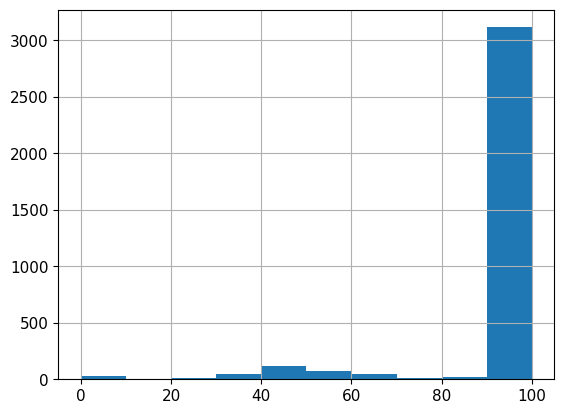

In [83]:
df_predict.sim_signer_yolov.hist()

### 2.3 Распознавание текста для dates

#### 2.3.1 Обучение модели. Получение метрик

При определении классов дат и номеров, в первую очередь необходимо разделить найденные текстовые сущности на рукописные и машинописные. Так как инструмент распознавания машинописного текста не справляется с задачей распазнования рукописных текстов. для рукописных текстов, в дальнейшем нужно обучить отдельную модель.
Для ывполнения задачи разделения текста на рукописный и машинописный  были выполнены следующие шаги:  
- создание датасета изображений боундинг боксов содержащих рукописные даты и рукописные исходящие номера по результатам предсказания модели model_5_classes.   
- разметка 500 документов на два класса; handwrite / typewriting  
- обучение модели на выборке из 400 документов.  

Метрики качества обученной модели приведены ниже в таблице

In [19]:
#TODO - создать выборку изображений на сервере МЭР
metrics = model_handwrite.val()

Ultralytics YOLOv8.0.58 🚀 Python-3.10.9 torch-2.0.0+cpu CPU
YOLOv8n summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /data/docs/vh/yolo/test_handwrite/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]
                   all        100        100      0.975      0.992       0.99      0.493
             handwrite        100         72      0.984      0.986      0.993      0.513
           typewritten        100         28      0.965      0.998      0.986      0.474
Speed: 0.3ms preprocess, 12.2ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val5


#### 2.3.2 Предсказание дат, получение метрик

In [84]:
df_predict['is_date'] = df_predict.out_reg_date == df_predict.predict_date

In [85]:
df_has_date = df_predict[~df_predict.predict_date.isin(['не определён','handwrite'])]

In [86]:
values = [len(df_predict[df_predict.predict_date == 'не определён']), 
          len(df_predict[df_predict.predict_date == 'handwrite']), 
          len(df_has_date[df_has_date.is_date == True]),
          len(df_has_date[df_has_date.is_date == False])]
keys = ['не определён', 'handwrite', 'True', 'False']
values

[1159, 602, 1649, 67]

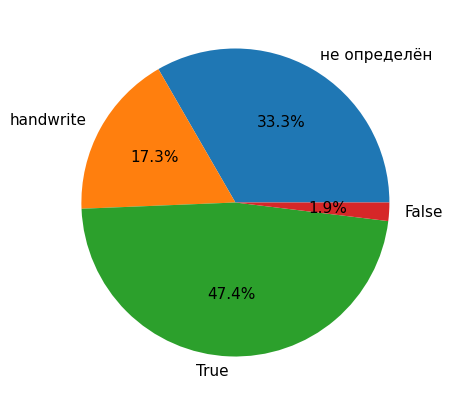

In [87]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.pie(values, labels=keys, autopct='%1.1f%%')
plt.show()

#### 2.3.3 Изучение ошибок

Распределение значений:  
- правильно определённые значения дат для машинописного текста 50.2%  
- рукописный текст 19.2%  
- текстовые сущности класса даты не найдены 20.5%  
- неверно определённые даты 10.2%  

Точность модели составляет на данный момент 50.2% но необходимо учитывать, что после обучения модели по распознанию рукописного текста, доля верно определённых дат увеличится. После изучения неверно определённых дат выясненно, что это в основном ошибки предсказания модели при предсказании класса даты, и ошибки распознания текста. Так например есть документы в которых цифра 6 распозналась как буква Б, или цифра 1 распозналась как латинская буква I. Во некоторых документах текст не правильно распознался в целом. Целесообразным видится улучшение метрики путём дообучения модели предсказания model_5_classes. Создание правил для уменьшения ошибок в распознании текста не целесообразно, так как такие правила только усложнят алгоритм и в конечном итоге такие правила могут меняться от выборки к выборке. Основная же задача исследования создать алгоритм с максимально возможным обобщением правил, для возможности переноса модели от заказчика к заказчику. Основное внимание стоит уделить созданию модели распознания рукописных текстов ,так как доля таких документов близка к 20%, а также к решению проблемы с отсутствующими значениями дат. Доля такой ошибки также в районе 20%

При изучении ошибок отсутствующих дат выявлена основная проблема:  
в файлах для каждого ID зачастую содержится более 1 документа пдф. Ранее была выбрана следующая логика выбора документа из множества - выбирался "верхний" документ имеющий индекс для параметра kind равный 0. при распознавании сендеров и сигнеров данный подход особо не влиял на скор, но при распознаннии дат и номеров оказалось, что при такой логике доля документов с отсутствующими датами и номерами равна 60%. Изучение таких документов выявило ,что при индексе равном нулю выбирается документ в котором отсутствуют дата и номер, если же выбрать документ с максимальным индексом, то дата и номер уже присутствуют.
ПРИМЕР:

In [88]:
# зададим для выбранного пути к документам индекс равный 0
xx = get_pdf_name(Path('/data/docs/vh/incoming_2023_feb/19b4ee94-64b2-4d58-b6f8-2b70c23d332e'), 0)
xx

PosixPath('/data/docs/vh/incoming_2023_feb/19b4ee94-64b2-4d58-b6f8-2b70c23d332e/1294bbdf-e467-4c07-91f2-ef83a0512068.pdf')

In [90]:
yolo.open_pdf(xx)

как видно дата и исходящий номер отсутствуют. Возьмём документ имеющий максимальный индекс для данного файла

In [91]:
# зададим для выбранного пути к документам индекс равный 1
xx = get_pdf_name(Path('/data/docs/vh/incoming_2023_feb/19b4ee94-64b2-4d58-b6f8-2b70c23d332e'), 1)
xx

PosixPath('/data/docs/vh/incoming_2023_feb/19b4ee94-64b2-4d58-b6f8-2b70c23d332e/a2b8716d-3eaf-4cec-9135-f3eb8cab5063.pdf')

In [92]:
yolo.open_pdf(xx)

на выходе получаем тот же документ, но с уже заполненными полями даты и  исходящего номера.

При изменении логики выбора документа с нулевого индекса на максимальный, доля документов не имеющих полей даты упала с 60% до 20.5%. При изучении оставшихся 20% ошибок выяснилось, что для этих документов в большинстве своём ошибкой является ошибка модели предсказания боундинг боксов, при которой поле даты вообще не предсказывается, хотя визуальный просмотр документа не выявил особенностей или нестандартностей такого поля. То есть, требуется дообучение моделей.

ВЫВОД: доля ошибок приходящаяся на неправильное определение даты составляет 10% и зависит от точности модели предсказания боундинг боксов и распознание текста. Улучшить резултаты можно только дообучением модели. Основные же ошибки имеющие наибольшие доли, это рукописные даты и  неопределённые даты.
Необходимо дообучить модель предсказания боундинг боксов и необходимо обучить модель по расспознаванию рукописного текста. 

### 2.4 Распознавание текста для NUMBERS

In [93]:
df_predict['is_number'] = df_predict['predict_number'] == df_predict['outgoing_number']
df_has_numbers = df_predict[~df_predict.predict_number.isin(['не определён', 'handwrite'])]

In [94]:
values = [len(df_predict[df_predict.predict_number == 'не определён']), 
          len(df_predict[df_predict.predict_number == 'handwrite']), 
          len(df_has_numbers[df_has_numbers.is_number == True]),
          len(df_has_numbers[df_has_numbers.is_number == False])]
keys = ['не определён', 'handwrite', 'True', 'False']
values

[869, 570, 1225, 813]

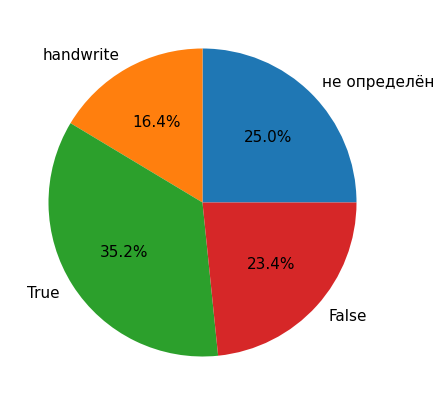

In [95]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.pie(values, labels=keys, autopct='%1.1f%%')
plt.show()

In [96]:
df_predict[['outgoing_number', 'predict_number']][df_predict.is_number == False].head(20)

,outgoing_number,predict_number
0,38/951,handwrite
4,б/н,не определён
5,3456п-П13,ж34561-1П13
8,18307-АЛ/12,не определён
10,06-06-20/28829,06-06-20/28829
11,646,19.3.63-6937
12,СМ-5017/12,©М-5017/2
13,20-2797-МС/23,handwrite
14,01-11/87,handwrite
17,-,не определён


Основная доля ошибок при предсказании номеров, это неверное распознание текста - пропуск букв, замена цифр на буквы и прочее.
логика ошибок связанная с руокписными номерами и отсутствующими номерами такая же ка и для дат.

ВЫВОД: скорее всего значительно увеличить качество предсказания номеров не получится, так как даже машинописные номера содержат в себе всевозможные символы и не имеют одинаковой структуры построения для всех номеров ( для каждого сендера используется своя логика), и сложно придумать алгоритм отчистки и фильтрации предсказанного текста. единственные методы улучшения метрик это создание модели распознавания рукописного текста для номеров и улучшение предсказательной способности модели предсказания боундинг боксов

### 2.5 Распознавание для content

In [97]:
from rapidfuzz import fuzz

contents = df_predict[df_predict.predict_content.notna()][['doc_id','content','predict_content']]
contents['sim'] = contents.apply(lambda row: fuzz.token_sort_ratio(row.content, row.predict_content), axis=1)

На данный момент алгоритмом поиска класса content является поиск в тексте документа строки с кратким описанием сущности документа. Такими сущностями обычно являются строки начинающиеся с "О" или "Об". Именно так и была обучена модель. при наличии такой строки в документе, такая строка определяется с малой долей ошибки ( для YOLO точность определения контента 96%).
Основная проблема начинается при сопоставлении предсказанного контента с истинным. При регистрации документов в поле контент обычно записывают не ту строку в документе, которая отвечает за содержание, а краткое содержание документа и обычно это краткое содержание является расширенной более информативной версией строки контента. Таким образом, предсказывание строки контент не несёт особого смысла, так как сама по себе она мало информативна. Возможная польза от предсказания строки контента это разбивка документов на определённые кластеры, хотя пользу от таких кластеров необходимо изучать дополнительно.

In [98]:
df_yolov.predict_content.notna().value_counts()

False    2407
True     1428
Name: predict_content, dtype: int64

In [99]:
clusters = pd.DataFrame(contents.predict_content.value_counts())
clusters[clusters['predict_content'] > 10]

,predict_content
О направлении информации,135
О предоставлении информации,43
О согласовании проекта документа,39
О представлении информации,22
О направлении уведомления,12


In [100]:
len(contents[contents.sim > 80]) / len(contents)

0.3686905632772495

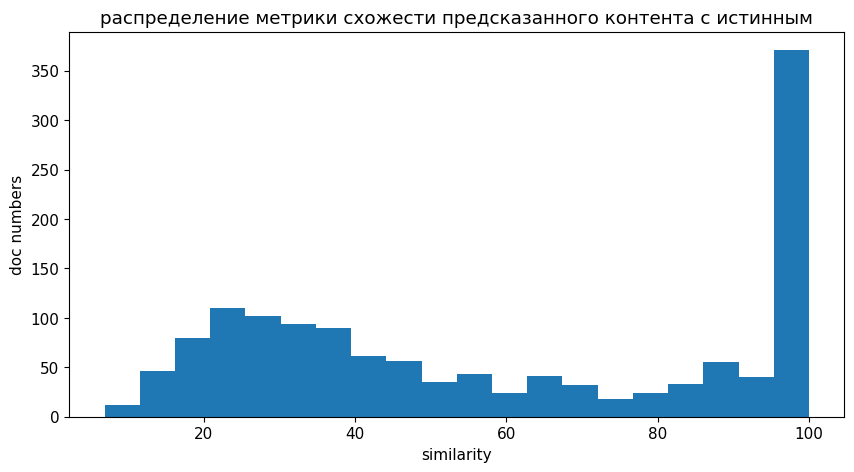

In [101]:
plt.figure(figsize=(10,5))
plt.hist(contents.sim.to_list(), bins=20)
plt.title('распределение метрики схожести предсказанного контента с истинным')
plt.xlabel('similarity')
plt.ylabel('doc numbers')
plt.show()

В дальнейшем предполагается использовать нейроную сеть (например BERT) для решения задачи сумаризации текста документа. Такой предсказанный контент будет более информативным

## 3. Определение идентификационных номеров 

### 3.1 Определение ID для senders

In [102]:
df_predict['is_sender'] =  df_predict.apply(lambda row: row.sender_id in row.predict_sender_id, axis=1 )

In [103]:
len(df_predict[df_predict.is_sender == True])/ df_predict.shape[0]

0.7742306586137475

После третьего этапа (поиск идентификационных номеров) точность определения сендера с 80% падает до 75%. Исследования основных причин ошибок выявили основную проблему для просадки в 5%. В самих справочниках содержится много "мусорной" информации, это и сочетаний одной или двух букв, сочетания небуквенных символов с буквенными символами, а также много дублирующихся строк, либо записанных одинаково, либо по разному для одной и той же организации, для которых назначаются разные идентификаторы. Для выявления дублирующихся организаций был создан специальный список датафреймов таких строк. В этом датафрейме есть и ошибочные строки, но саму суть проблемы он передаёт.

In [104]:
partners = pd.read_csv('/data/assets/partners.csv', encoding='windows-1251')
partners = ref.update_partners(partners)

In [105]:
def get_counts_multi_true_senders(df):
    return df[df.is_sender == True].predict_sender_id.agg(len).value_counts().index.to_list()

def get_index_multi_true_senders(df, count):
    multi_true = df[df.is_sender == True]
    multi_true['len_sender'] = multi_true[multi_true.is_sender == True].predict_sender_id.agg(len) == count
    
    once_org =  multi_true[multi_true.len_sender == True]
    return once_org.predict_sender_id.apply(tuple, 1).drop_duplicates().apply(list).to_frame().index.to_list()

def get_df_with_multi_true_senders(ref,df, index):
    return ref[ref.partner_id.isin(df.loc[index]['predict_sender_id'])]

def get_list_of_dfs_with_multi_true_senders(ref, df):
    
    counts = get_counts_multi_true_senders(df)
    list_multi_true_senders = []
    for count in counts:
        if count > 1:
            indexes = get_index_multi_true_senders(df, count)
            for index in indexes:
                list_multi_true_senders.append(get_df_with_multi_true_senders(ref, df, index))

    return list_multi_true_senders

In [106]:
# df_predict.predict

In [107]:
df_multi = get_list_of_dfs_with_multi_true_senders(partners, df_predict)

/tmp/ipykernel_1811/2263262688.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_true['len_sender'] = multi_true[multi_true.is_sender == True].predict_sender_id.agg(len) == count
/tmp/ipykernel_1811/2263262688.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_true['len_sender'] = multi_true[multi_true.is_sender == True].predict_sender_id.agg(len) == count
/tmp/ipykernel_1811/2263262688.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [108]:
len(df_multi)

185

In [109]:
df_multi[0]

,partner_id,partner_name,partner_full_name,partner_type,partner_not_available
7697,c28e61d0-cd45-4bba-9f12-c8dd9f3c5f7f,#минстрой россии,министерство строительства и жилищно-коммуналь...,0,False
71980,852580b7-40e6-4b75-85c2-e2801a625c1e,_министерство,NaN,0,False
74050,5f32ddd3-ce8e-4a10-907f-d97c9e14f355,рст,NaN,0,False


In [110]:
df_multi[2]

,partner_id,partner_name,partner_full_name,partner_type,partner_not_available
9108,c688ea6a-5d3d-4ac4-bc9e-c8875aeb58c7,#росрыболовство,федеральное агентство по рыболовству (росрыбол...,0,False
108072,2c9dd2b4-4472-40d4-a890-602d76c5a826,федеральное,NaN,0,False
115638,505ece40-d30a-4b00-bf72-768bab071715,федеральное агентство по рыболовству,NaN,0,False


In [111]:
df_multi[3]

,partner_id,partner_name,partner_full_name,partner_type,partner_not_available
8425,df7dc2cc-cdac-4b39-b631-3e9097dc6872,#правительство кабардино-балкарской республики,правительство кабардино-балкарской республики,0,False
44350,3faef2ed-8bae-42d2-9074-41d7e6d3927b,_рави,NaN,0,False
66008,2dad6830-e820-4391-b7ef-f98f118ab7c1,_ави,NaN,0,False


In [112]:
df_multi[4]

,partner_id,partner_name,partner_full_name,partner_type,partner_not_available
9171,ef183f4a-ba1a-4ee5-8708-794c19734950,#роструд,федеральная служба по труду и занятости (роструд),0,False
25906,ddf087c1-0ee2-421f-b143-6c9461e7c7e8,_федеральная служба по труду и занятости (рост...,NaN,0,False
34164,cc7bcad0-0e7b-48b3-993f-d90e850f3f47,_федеральная служба по труду и занятости,NaN,0,False


In [113]:
df_multi[5]

,partner_id,partner_name,partner_full_name,partner_type,partner_not_available
9975,a6d86e1d-0bf3-4a2a-8881-6bd190c4a8ad,#банк россии,банк россии,0,False
67073,c70d6ade-163b-4898-b027-10706e8cf4a7,банк россии,NaN,0,False
95728,ef977b90-0315-4c5b-828f-4c1a12d84836,банк россии,NaN,0,False


ВЫВОД:  
    модель справляется с задачей определения идентификационных номеров с точностью в 75%. Дальнейшей увеличение точности связанно с улучшением справочной информации.

### 3.2 Определение ID для signers

In [114]:
df_predict['is_signer'] = df_predict.apply(lambda row: row.signer_id in row.predict_signer_id, axis=1)
df_predict.is_signer.value_counts()

True     2452
False    1025
Name: is_signer, dtype: int64

In [115]:
len(df_predict[df_predict.is_signer == True])/ df_predict.shape[0]

0.7052056370434282

Наиболее интересными являются ошибки в случае, когда мы правильно предсказываем ID для сендера, но при этом не находим  для таких сендеров правильные ID сигнеров, учитывая что сами ФИО предсказаны верно.

In [116]:
df_false_signer = df_predict[(df_predict.is_signer == False) & (df_predict.is_sender == True)]
len(df_false_signer)

240

In [117]:
df_false_signer['sim_signer'] = df_false_signer.apply(lambda row: fuzz.token_sort_ratio(row.signer, row.predict_signer) 
                                                      if type(row.signer) == str else 0, axis=1 )

/tmp/ipykernel_1811/2958008260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_false_signer['sim_signer'] = df_false_signer.apply(lambda row: fuzz.token_sort_ratio(row.signer, row.predict_signer)


In [118]:
df_false_signer[df_false_signer.sim_signer > 90][['signer', 'predict_signer', 'signer_id', 
                                                  'predict_signer_id', 'sim_signer' ]].head(20)

,signer,predict_signer,signer_id,predict_signer_id,sim_signer
24,Семёнов Д.Б.,Семёнов Д.Б.,db91f6c4-8b0a-4fae-8669-8cb3cec0c221,[],100.000000
31,Беспрозванных А.С.,А.С Беспрозванных и,4f52de4c-d1f5-40d6-9ca3-2afd8d5d8060,[],94.444444
48,Сёмка С.Н.,Сёмка С.Н.,c9fbbc29-6d25-4376-a236-79f95617698d,[],100.000000
149,Ковалёва Е.Л.,Ковалёва Е,01f2c7a6-b7d7-4758-86ff-6eb6bf713697,[],90.909091
166,Турусбеков Д.Б.,Турусбеков Д.Б.,f20d5ad1-bcab-4645-aafe-59181a14426d,[d573eefc-3c57-452b-81e0-badb2dd6b204],100.000000
217,Ковалёва Е.Л.,Ковалёва Е,01f2c7a6-b7d7-4758-86ff-6eb6bf713697,[],90.909091
226,Сёмка С.Н.,Сёмка С.Н.,c9fbbc29-6d25-4376-a236-79f95617698d,[],100.000000
240,Богашов А.Е.,Богашов А.Е.,1c0e350e-42d0-4c22-a896-ff2847aea43c,[],100.000000
256,Киселев М.С.,Киселёв М.С.,af3aefa4-3125-483b-adf3-0ab7f96a32d2,[],90.909091
300,Чумаков С.В.,Чумаков С.В.,43dc16fd-40f8-4054-b5e3-597eadc8be5b,[],100.000000


In [119]:
df_false_signer[df_false_signer.sim_signer < 90].shape[0]

141

In [120]:
df_false_signer.sim_signer.value_counts().sort_index(ascending=False).head(10)

100.000000    77
95.238095      1
94.444444      1
93.333333      1
91.666667      4
90.909091     14
90.000000      1
88.888889      3
88.000000      2
87.500000      3
Name: sim_signer, dtype: int64

как видно, основная доля предсказанных сигнеров предсказанна верно (sim >=90). Из 488 документов для которых верно предсказан ID сендера, но не верно предсказан ID сигнера верно предсказаны 119+9+165+1 = 294 сигнера. Это 5.8% от всех документов. 

In [121]:
df_false_signer['signer'].value_counts()

Баталина О.Ю.      13
Соколов В.И.        9
Кущ И.А.            7
Ковалёва Е.Л.       6
Костюченко И.В.     5
                   ..
Ковалев В.В.        1
Ушаков Д.В.         1
Владимиров С.В.     1
Онищенко В.В.       1
Рафикова Л.А.       1
Name: signer, Length: 160, dtype: int64

Очевидно, что значительную ошибку вносит сигнер Мишустин М. В. 120 случаев из 5000 это 2.5% ошибки. Оказывется в справочной информации для employee_id = '7c769d0e-5361-4bef-b8e6-4b97ef12e03d' ( истинный id сигнера) существует работник Мишустин, но записанный как "Мишустинмв" соответственно для алгоритма, который ищет точное совпадение по фамилиям, такой работник не является валидным так как точного совпадения нет и модель ищет другие схожие варианты. Надо отметить, что в справочнике нет полного верного ФИО для "Мишустина М. В.", так как столбец first_name в справочнике для фамилии "Мишустин" вообще не содержит убукву "М". Та же поблема верна и для работников "Осауленко" и "Ковалёва", в справочнике они записаны как "Осауленкоал" и "Ковалва"

In [122]:
partners_employees = pd.read_csv('/data/assets/partners_employees.csv', encoding='windows-1251')
partners_employees = ref.update_partners_empoyees(partners_employees)

In [123]:
partners_employees[partners_employees.employee_id.isin(['7c769d0e-5361-4bef-b8e6-4b97ef12e03d',
                                                        '6584d0a0-84c3-4cbe-95b2-fc9c9f8e7b5c',
                                                        '01f2c7a6-b7d7-4758-86ff-6eb6bf713697']) ]

,employee_id,middle_name,first_name,last_name,employee_not_available,partner_id,split_fio
96611,01f2c7a6-b7d7-4758-86ff-6eb6bf713697,Е,Л,Ковалва,True,740cff53-ef67-48f3-800e-8184fbf4e874,"[Ковалва, Е, Л]"
188104,7c769d0e-5361-4bef-b8e6-4b97ef12e03d,None,None,Мишустинмв,True,f8b1bfcb-dcbd-45e6-8a99-c82a103033f1,"[Мишустинмв, None, None]"
559924,6584d0a0-84c3-4cbe-95b2-fc9c9f8e7b5c,None,None,Осауленкоап,False,a88e9773-86ce-48ed-84b4-52a214517349,"[Осауленкоап, None, None]"


In [124]:
df_false_signer[df_false_signer.signer == 'Цабиев Т.А.'][['doc_id','signer', 'predict_signer', 'signer_id', 
                                                            'predict_signer_id', 'sim_signer']]

,doc_id,signer,predict_signer,signer_id,predict_signer_id,sim_signer
2258,0ee063cb-e572-4a20-b342-e3d8b7378094,Цабиев Т.А.,не определён,0105fce2-d6b9-4d15-a4cc-d5aed6acc21f,[],18.181818
3488,fcf8563e-abef-4c37-bb54-952ca05cef7c,Цабиев Т.А.,не определён,0105fce2-d6b9-4d15-a4cc-d5aed6acc21f,[],18.181818


Для документов содержащих подписанта "Цабиев Т. А." ни в одном документе не был предсказан подписант, имеет смысл посмотреть на такие документы.

In [125]:
# df_false_signer[df_false_signer.predict_signer == 'не определён']

In [126]:
none_list = df_false_signer[df_false_signer.predict_signer == 'не определён'].doc_id.to_list()
none_list[13]

'26fd2f62-250a-43be-b3d9-715e79fb29ac'

In [127]:
len(none_list)

63

In [128]:
x1 = '/data/docs/vh/incoming_2023_feb/cc527e7d-923e-4690-bbe0-210083482049/8e5195f7-f1ce-467d-8c22-5eef3bc49916.pdf'
x2 = '/data/docs/vh/incoming_2023_feb/f5fe9033-19de-4f6e-8486-36a66adb6391/9f40bf42-299c-44d6-a7e3-ce2aba230fb5.pdf'
x3 = '/data/docs/vh/incoming_2023_feb/01253736-eded-4437-9707-1332952cb155/dd08df7f-177f-4456-812a-a97cb2c6e817.pdf'
x4 = '/data/docs/vh/incoming_2023_feb/a4643e56-22fd-4374-b928-b89b629be4eb/c38bc2ba-b7f1-40a3-9b44-c1ad9727775b.pdf'
x5 = '/data/docs/vh/incoming_2023_feb/01a053c6-dbcf-4823-9dfa-a3956d19dddb/2e1412b2-c677-4f1f-8685-d0f87035c5a4.pdf'
yolo.open_pdf(x1)

Для данных документов неверными оказались предсказания модели YOLO, вернее отсутствие предсказанных сигнеров. Количество документов в которых не были предсказанны сигнеры, но верно были предсказаны ID сендеров равно 60 или 1.2%  
Если учитывать неверно записанных сигнеров в справочной информации, то скор можено поднять на 3.86% так как по факту сигнеры были найдены верно.
Точность предсказания для  ID сигнеров не может превышать точности предсазания ID сендеров, так как ID сигнеров ищутся по ID сендеров. Точность для sender id = 75.3% а для signer id = 65.6%, то есть иными словами доля ошибки для ID сигнеров составляет 9.7%. Из этих 9.7% ошибки распределяются следующим образом:  
 - не верно предсказанные сигнеры (sim < 90, а значит есть ошибки в фамилии) = 3.88%  
 - верно предсказанные сигнеры, но в справочнике нет верных фамилий = 3.86%  
 - отсутствие предсказанных сигнеров = 1.2% 
 - остальные ошибки = 0,76%
 

## 4. Общие метрики качества модели

**1 этап: Оценка качества предсказаний YOLO:**   
> precision - 0.936    
recall - 0.923  

**2 этап: Оценка качества предсказаний текстовых сущностей для классов:**   
> *sender*: recall=0.86, precision=0.76  
*signer*: simylarity > 90% accuracy = 0.92  
*date*: accuracy=41%  
*numbers*: accuracy=35.3%  
*content*: simylarity > 80% accuracy = 0.368 

**3й этап: Оценка качества предсказаний ID для sender и signer:**    
> *sender*: accuracy = 0.753  
*signer*: accuracy = 0.656  
    
    

## 5. Общие выводы

#### 1 Этап: 
> Модель YOLOv8 достаточно хорошо справляется с нахождением bounding boxes в документах, особенно для тех классов, которые имеюют особые маркеры (позиция в документе, заглавные буквы, жирный шрифт и т.д.). Модель YOLO можно применять для того вида документации, которая имеет ярко выраженную и постоянно повторяющуюся  структуру - письма, заявления, чеки, обращения, чертежи, паспорта, водительские права, накладные и прочее. Большая часть документации имеет структурированный вид, что позволяет использовать YOLO в широком спектре задач определения текста в документах. Для этого достаточно для каждого отдельного вида документации дообучивать новую модель на нескольких сотнях экземпляров документов принадлежащих к одному и тому же виду. Возможно использование дополнительной модели, которая на входе определяет вид документа, а далее направляет документ к той или иной специально обученной модели YOLO. Представленная модель YOLOv8 нуждается в дополнительной настройке и дообучении для повышения метрик качества, нужны "тонкие" настройки.  

#### 2 Этап:
> Основное количество ошибок при предсказании класса сендер, это ошибки разночтения сущностей или наличие в справочной информации дублирующихся сущностей или неверно записанных, "мусорных". Реальной оценкой качества на втором этапе может являться оценка после работы модели в бизнес процессе в течении месяца (в месяц накапливается более 10 000 экземпляров документов, что вполне достаточно для анализа и оценки). Для этого необходимо накопить информацию о предсказаниях (верно\не верно предсказанные id). Помимо реальной оценки качества модели, такая информация поможет выявить иные проблемы, которые сейчас возможно найти только при глубоком анализе всех ошибок.  
Сигнер находится с точностью более 92%, что сопоставимо с предсказательной возможностью на 1м этапе.  
Для лучшего предсказания дат и номеров следует дополнительно обучить две модели распознавания рукописного текста. Две модели необходимы потому что у дат и номеров разная структура. Даты в основном стурктуированны двумя способами:  
'dd.mm.yyyy' / 'dd.mm.yy' и 'dd "month" yyyy', таким образом для модели распознавания дат будет относительно легко найти основные маркеры построения сущности даты и распознать их. Для рукописных номеров всё сложнее, так как в номерах используются все возможные символы и нет одинаковой структуры построения для всех номеров. Для модели распознания дат необходимо использовать логику при которой размеченной датой является вся дата целиком и в саму модель подаётся всё изображение целиком. Для модели распознания номеров, возможно наилучшим подходом будет тот при котором на вход подаётся не изображение номера, а отдельные символы и задача модели распознать каждый такой символ. В любом случае, выбор правильной модели возможен только после проведения соответствующих исследований.

#### 3 Этап:  
> Основная ошибка при предсказании ID сендера также связана с разночтениями в справочнике, мусорной информацией и дублирующимися организациями. Реальной оценкой точности может также служить информация после месячной загрузки модели.
При предсказании сигнера важно помнить, что точность предсказания напрямую связанна с точностью предсказания сендера и не может превышать её. Таким образом при точности 65.6% надо учитывать что основную ошибку в 24.7% вносит неверное предсказание сендера. Основная доля ошибок (5.08%) связана с неправильным предсказанием модели YOLO или отсутствием предсказаний, остальная часть в основном связана с некорректной информацией в справочнике (4.62%).  

#### Работоспособность модели для бизнес задач: 
Таким образом для бизнес задач в которых необходимо входящий документ не только зарегистрировать, но и привязать к существующим ID, точность может достигать 80% для существущей модели и существующих справочников. При наличии справочников без разночтений, коротких записей, дублирующихся строк, точность может достигать точности предсказания на этапе YOLO, то есть боле 90%.  
Для бизнес задач где требуется фактическое считывание информации с документа (чеки, права, паспорта, накладные) без привязки к ID, данная модель может работать без особого падения качества на всех этапах (1 этап -  YOLO, 2 этап - распознавание текста) с точностью сравнимой с точностью предсказаний YOLO (более 90%). Это же верно и для задач при которых данная модель будет автоматически привязана к созданию своих автоматизированных справочников. То есть, модель предсказывает сущности, если сущностей нет в справочнике (изначально справочник пуст) то модель вносит соответствующие строки в справочник и привязывает ID. Такая реализация возможна для бизнес задач в которых ещё нет спрвочной информации и нет системы автоматического распознования сущностей.  
#### Дальнейшие действия по улучшению предсказательной способности модели:  
1. При достаточном накоплении рукописных номеров и дат и наличии разметки к ним, можно обучить модель на распознание рукописных текстов. Задача с большой вероятностью реальна ( в основном для дат), так как на данном этапе имеется несколько десятков тысяч документов с рукописными полями и соответствующей им мета информацией. 
2. на данном этапе предсказание класса контент не является особо информативным, так как модель находит поле о номенклатурной принадлежности документа но не о его содержании. Часто поле номенклатурной принадлежности документа содержит в полном объёме краткое содержание. Для данной модели правильно определенно 36%  экземпляров с кратким содержанием. Данные предсказания могут быть полезны, если будет необходимость разбивать документацию по кластерам номенклатурной принадлежности. Для определения краткого содержания документа необходимо обучить дополнительную модель ( например BERT). Вся необходимая информация для этого есть.  
3. для сравнительной оценки работоспособности модели, нужно получить метрики качества на одних и тех же данных для модели использующей классический ML и правила, и для трёх этапной представленной модели - YOLO/text_recognition/matching_ID  

# Предсказательная модель на основе ML